In [1]:
import datetime
import random
import csv
import paramiko
import logging
import time
from multiprocessing import Pool

# Configure logging
timestamp = datetime.now().strftime("%Y_%b_%d_%H%M")  # Example: 2024_Oct_20_1930

logging.basicConfig(level=logging.INFO, format='%(asctime)s [%(processName)s] %(message)s', filename=f'{timestamp}_bandwidth_injection.log')

# Function to generate a bandwidth matrix for a given number of nodes
def generate_bandwidth_matrix(num_nodes, min_bandwidth=200, max_bandwidth=600):
    bandwidth_matrix = [[0 if i == j else random.randint(min_bandwidth, max_bandwidth)
                         for j in range(num_nodes)] for i in range(num_nodes)]
    return bandwidth_matrix

# Generate bandwidth matrix for 9 nodes
num_nodes = 9
bandwidth_matrix = generate_bandwidth_matrix(num_nodes, min_bandwidth=200, max_bandwidth=800)

bandwidth_matrix

[[0, 594, 659, 437, 345, 550, 277, 755, 659],
 [251, 0, 512, 270, 432, 404, 274, 625, 386],
 [721, 512, 0, 485, 300, 439, 340, 234, 751],
 [427, 772, 201, 0, 692, 238, 427, 594, 252],
 [385, 398, 467, 622, 0, 288, 501, 502, 683],
 [675, 779, 247, 229, 484, 0, 429, 230, 698],
 [555, 467, 240, 534, 580, 202, 0, 449, 737],
 [313, 361, 427, 628, 419, 707, 564, 0, 393],
 [605, 400, 346, 693, 372, 748, 783, 566, 0]]

In [2]:


# List of node names to map to bandwidth matrix indices
node_names = [
    'k8s-worker-1', 'k8s-worker-2', 'k8s-worker-3', 'k8s-worker-4',
    'k8s-worker-5', 'k8s-worker-6', 'k8s-worker-7', 'k8s-worker-8', 'k8s-worker-9'
]

# Function to execute commands via SSH
def execute_ssh_command(client, command):
    stdin, stdout, stderr = client.exec_command(command)
    stdout_output = stdout.read().decode().strip()
    stderr_output = stderr.read().decode().strip()
    if stderr_output:
        logging.error(f"Error executing command: {command}\n{stderr_output}")
    return stdout_output, stderr_output

# Function to apply bandwidth settings between nodes
def apply_bandwidth_between_nodes(source_node_name, username, key_path, interface, bandwidth_matrix, node_details, node_names):
    client = paramiko.SSHClient()
    client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    client.load_system_host_keys()

    try:
        source_node_ip = node_details[source_node_name]['ip']
        client.connect(source_node_ip, username=username, key_filename=key_path)

        # Clear existing rules and set root qdisc
        execute_ssh_command(client, f"sudo tc qdisc del dev {interface} root || true")
        execute_ssh_command(client, f"sudo tc qdisc add dev {interface} root handle 1: htb default 9999")
        logging.info(f'Bandwidth cleared and root qdisc set for {source_node_name}')

        # Get the index of the source node
        source_index = node_names.index(source_node_name)

        for dst_node, details in node_details.items():
            if dst_node == source_node_name:
                continue

            dst_node_ip = details['ip']
            dst_index = node_names.index(dst_node)
            bandwidth = bandwidth_matrix[source_index][dst_index]

            # Assign unique class ID for each destination
            class_id = f"1:{dst_index + 1}"  # Unique class ID
            logging.info(f'Setting bandwidth between {source_node_name} and {dst_node}: {bandwidth} Mbps')

            # Add traffic class
            execute_ssh_command(client, f"sudo tc class add dev {interface} parent 1: classid {class_id} htb rate {bandwidth}mbit")
            # Add filter for target IP
            execute_ssh_command(client, f"sudo tc filter add dev {interface} protocol ip parent 1: prio 1 u32 match ip dst {dst_node_ip} flowid {class_id}")
            logging.info(f'Bandwidth set between {source_node_name} and {dst_node}: {bandwidth} Mbps')

    except Exception as e:
        logging.error(f"Failed to set bandwidth for {source_node_name}: {e}")
    finally:
        client.close()

# Function for multiprocessing
def automate_bandwidth_injection(params):
    source_node_name, bandwidth_matrix, node_details, node_names = params
    username = node_details[source_node_name]['username']
    key_path = node_details[source_node_name]['key_path']
    interface = 'eth0'  # Assuming the interface name is eth0
    apply_bandwidth_between_nodes(source_node_name, username, key_path, interface, bandwidth_matrix, node_details, node_names)

# Node details with IPs and SSH credentials
node_details = {
    'k8s-worker-1': {'ip': '172.26.128.30', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-2': {'ip': '172.26.132.91', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-3': {'ip': '172.26.133.31', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-4': {'ip': '172.26.132.241', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-5': {'ip': '172.26.132.142', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-6': {'ip': '172.26.133.55', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-7': {'ip': '172.26.130.22', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-8': {'ip': '172.26.130.82', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'},
    'k8s-worker-9': {'ip': '172.26.133.118', 'username': 'ubuntu', 'key_path': '/home/ubuntu/.ssh/id_rsa'}
}

# Prepare parameters for parallel execution
params_list = [(source_node, bandwidth_matrix, node_details, node_names) for source_node in node_details.keys()]

if __name__ == '__main__':
    with Pool(processes=len(node_details)) as pool:
        pool.map(automate_bandwidth_injection, params_list)


In [4]:
node_names = [
    'k8s-worker-1', 'k8s-worker-2', 'k8s-worker-3', 'k8s-worker-4',
    'k8s-worker-5', 'k8s-worker-6', 'k8s-worker-7', 'k8s-worker-8', 'k8s-worker-9'
]
node_names.index('k8s-worker-2')

1

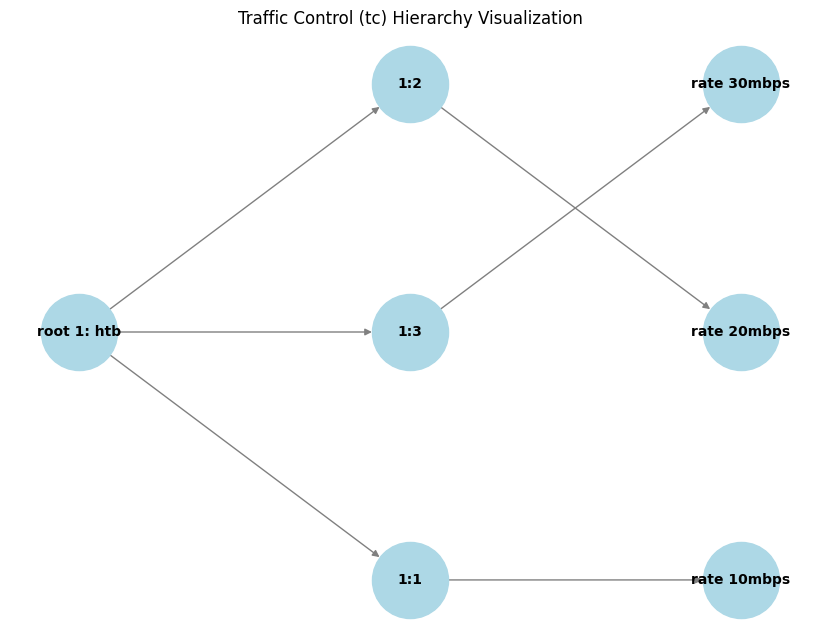

In [1]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph for the `tc` hierarchy
tc_graph = nx.DiGraph()

# Add nodes for the root and child classes
tc_graph.add_node("root 1: htb", layer=0)
dest_nodes = ["1:1", "1:2", "1:3"]
for node in dest_nodes:
    tc_graph.add_node(node, layer=1)
    tc_graph.add_edge("root 1: htb", node)

# Add details for qdisc under each class (rate)
qdisc_nodes = ["rate 10mbps", "rate 20mbps", "rate 30mbps"]
for i, qdisc in enumerate(qdisc_nodes):
    tc_graph.add_node(qdisc, layer=2)
    tc_graph.add_edge(dest_nodes[i], qdisc)

# Draw the graph using matplotlib
pos = nx.multipartite_layout(tc_graph, subset_key="layer")
plt.figure(figsize=(8, 6))
nx.draw(tc_graph, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", edge_color="gray")

plt.title("Traffic Control (tc) Hierarchy Visualization")
plt.show()
